In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth',200)
#显示所有列，把行显示设置成最大
pd.set_option('display.max_columns', None)
#显示所有行，把列显示设置成最大
pd.set_option('display.max_rows', None)

In [201]:
df = pd.read_excel('./第一部分数据机器学习用（剔除无差异指标）.xlsx')

In [202]:
dst_label = [1,2]
df  = df[df['组别'].isin(dst_label)]
df['label'] = df['组别']
df.drop('组别',axis=1,inplace=True)

In [203]:
df.head()

,Participant,指标1,指标5,指标6,指标7,指标8,指标9,指标10,指标11,指标12,指标13,指标14,指标15,指标16,指标17,指标18,指标19,指标20,label
0,A1,6.925000,136.807500,3.365000,1557.625000,480.266667,48.533333,3.133333,898.533333,55.433333,99.400000,0.075,162.116667,98.933333,12.866667,5350.450000,134.966667,305.283333,1
1,A2,3.948718,171.351282,5.782051,667.435897,716.600000,34.266667,7.733333,12739.566667,291.666667,417.233333,1.000,181.750000,94.100000,10.933333,7607.600000,139.783333,392.583333,1
2,A3,12.600000,71.377500,3.860000,2061.125000,520.350000,62.650000,10.350000,5318.550000,133.700000,253.250000,0.450,149.416667,95.516667,9.816667,5429.700000,103.550000,308.050000,1
3,A4,10.351351,60.081081,2.994595,861.405405,577.233333,55.566667,4.166667,1679.700000,66.166667,134.766667,0.475,233.300000,71.700000,7.400000,4585.783333,107.316667,241.283333,1
4,A5,9.257143,115.180000,4.520000,1563.028571,647.533333,48.533333,2.600000,1098.666667,55.000000,112.866667,0.575,112.100000,69.766667,11.133333,9849.150000,159.900000,360.233333,1


## 正负样本比例

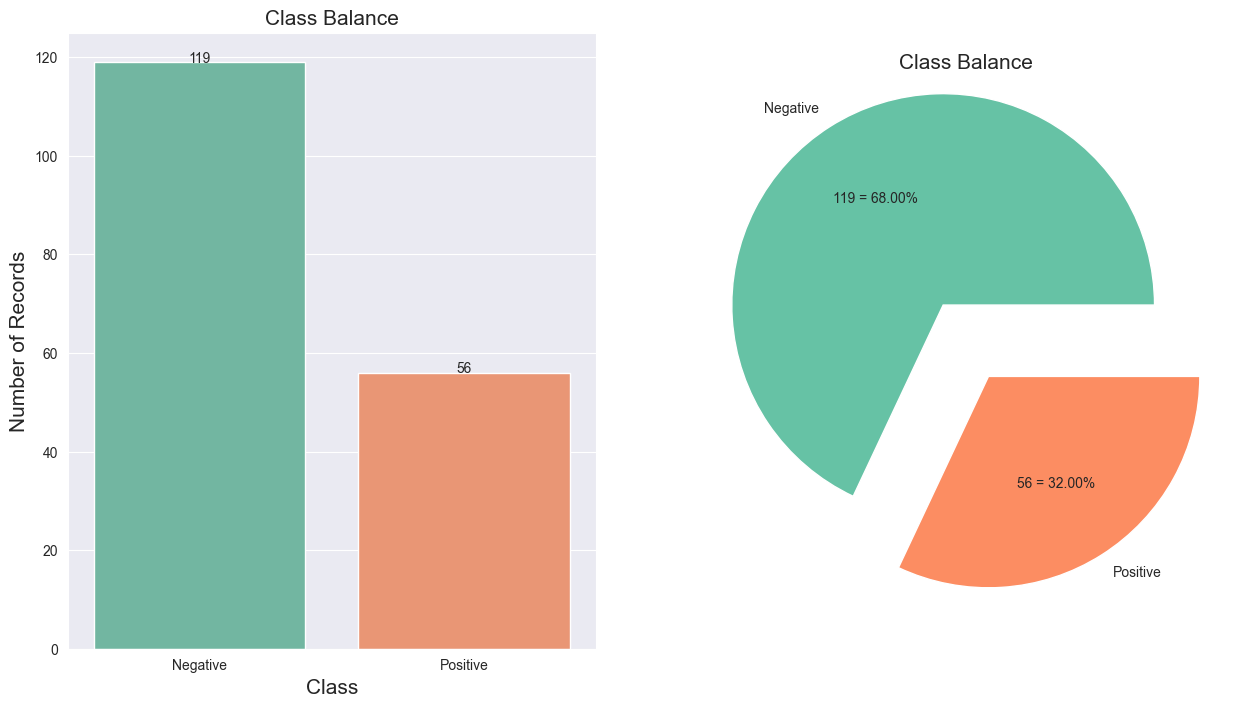

In [205]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.set_style('darkgrid')
sns.set_palette('Set2')

counts = pd.DataFrame(df["label"].value_counts()).rename(index={1: "Negative", 2: "Positive"})
_ = sns.barplot(x=counts.index, y=counts.label, ax=axs[0])
for p in axs[0].patches:
    axs[0].text(x=p.get_x()+(p.get_width()/2), y=p.get_height(), s="{:,d}".format(round(p.get_height())), ha="center")
_ = axs[0].set_title("Class Balance", fontsize=15)
_ = axs[0].set_ylabel("Number of Records", fontsize=15)
_ = axs[0].set_xlabel("Class", fontsize=15)

data = [
    df[(df["label"] == 1)]["Participant"].count(),
    df[(df["label"] == 2)]["Participant"].count()
]
_ = axs[1].pie(
    data, labels=["Negative", "Positive"],
    autopct=lambda x: "{:,.0f} = {:.2f}%".format(x * sum(data)/100, x),
    explode=[0.20] * 2, 
    colors=sns.color_palette("Set2")[0:2],
)
_ = axs[1].set_title("Class Balance", fontsize=15)

## 空缺值检测

In [150]:
#============= 缺失率 ================  
#行缺失
def idx_missing(data,features):
    total=data[features].isnull().sum(axis=1).sort_values(ascending=False)
    percent=total/len(features)
    missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    return missing_data
# 列缺失
def col_missing(data,features):
    total=data[features].isnull().sum().sort_values(ascending=False)
    percent=total/len(data)
    missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
    return missing_data

In [151]:
features = df.columns.to_list()
# 行缺失处理
idx_missing_data=idx_missing(df,features)
idx_miss_drop=idx_missing_data[idx_missing_data.Percent>0.7].index.to_list()
print('行缺失率大于70%的行index为：====》{0}'.format(idx_miss_drop))
df = df.drop(idx_miss_drop,axis=0)
#列缺失和唯一值处理
# col_missing_data=col_missing(df,num_fea+cat_fea)
col_missing_data=col_missing(df,features)
miss_drop=col_missing_data[col_missing_data.Percent>0.80].index.to_list()
print('列缺失率大于80%的列columns为：====》{0}'.format(miss_drop))

行缺失率大于70%的行index为：====》[]
列缺失率大于80%的列columns为：====》[]


## 缺失值可视化

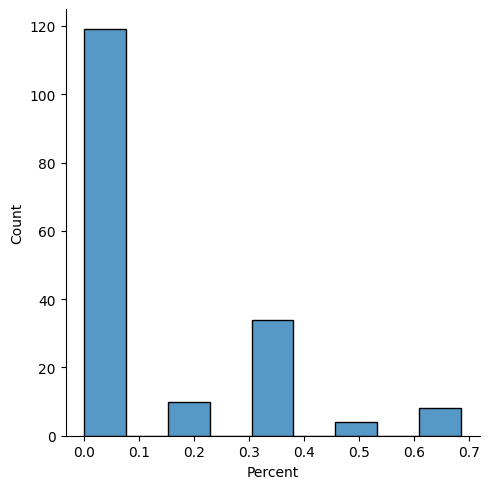

In [152]:
sns.displot(idx_missing_data, x="Percent")
plt.show()

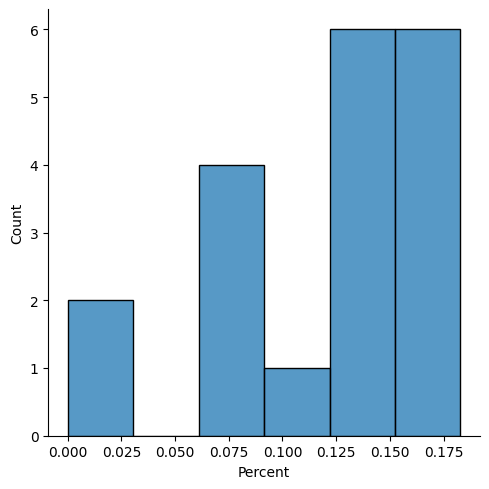

In [153]:
sns.displot(col_missing_data, x="Percent")
plt.show()

## 空缺值填充

In [154]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
num_fea.remove('label')
# 众数统计
mod_dic = df[cat_fea].mode(dropna=True).iloc[0,:].to_dict()
num_dic = df[num_fea].median(skipna=True).to_dict()
df.loc[:,num_fea] = df.loc[:,num_fea].fillna(value=num_dic)
df.loc[:,cat_fea] = df.loc[:,cat_fea].fillna(value=mod_dic)
df.dropna(how='any',inplace=True)

## 时间特征衍生

In [185]:
def func(data,flag):
    weekday = data['AlarmTimeStamp'].dayofweek
    hour =  data['AlarmTimeStamp'].hour
    if flag=='weekend':
        if weekday > 4:
            return 'yes'
        else:
            return 'no'
    elif flag=='weekday':
        return weekday
    else:
        if (hour > 6) &(hour < 12):
            return 'am'
        elif hour < 18:
            return 'pm'
        else:
            return 'night'  

source_col = ['AlarmTimeStamp','ParameterTimeStamp','RecordTimeStamp']
ins_col = ['weekend','weekday','amOrpmOrnight']
time_fea_tag = False
if time_fea_tag:
    for tmp_source_col in source_col:
        df[tmp_source_col] = pd.to_datetime(df[tmp_source_col],format='%Y-%m-%d %H:%M:%S')
        for tmp_ins_col in ins_col:
            dst_col = tmp_source_col+'_'+tmp_ins_col
            df[dst_col] = df.apply(func,args=(tmp_ins_col,),axis=1)
    df.drop(source_col,axis=1,inplace=True)

## 常变量检测

In [155]:
#  * unique过滤
def uni(data,features):
    temp=[data[item].nunique()  for item in features]
    feature_unique=pd.DataFrame()
    feature_unique['feature_name']=features
    feature_unique['unique']=temp
    feature_unique=feature_unique.sort_values(by='unique',ascending=False)
    return feature_unique

# 剔除单个特征值占比较高的特征
def ferq(data,features):
    temp = list()
    for var1 in features:
        if data[var1].value_counts(dropna=False, normalize=True).max() > 0.90:
            temp.append(var1)
    return temp
# 标准差过滤
def std_fea(data,feature):
    temp = data[feature].describe()
    temp = temp.transpose()
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':'feature_name'},inplace=True)
    temp = temp[['feature_name','std']]
    temp.sort_values(by='std',ascending=True,inplace=True)
    return temp

In [156]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
all_fea = df.columns.to_list()
all_fea.remove('label')
num_fea.remove('label')
# 唯一值筛查
feature_unique=uni(df,cat_fea)
unique_drop=feature_unique.loc[feature_unique['unique']==1,'feature_name'].to_list()
print('特征值唯一的列columns为：====》{0}'.format(unique_drop))
# 特征值占比筛选
frep_drop=ferq(df,all_fea)
print('单特征值占比超过95%列columns为：====》{0}'.format(frep_drop))
# 均方差筛查
feature_std=std_fea(df,num_fea)
std_fea_drop=feature_std[feature_std['std'] < 0.10]['feature_name'].to_list()
print('标准差小于10%的特征为：====》{0}'.format(std_fea_drop))

特征值唯一的列columns为：====》[]
单特征值占比超过95%列columns为：====》[]
标准差小于10%的特征为：====》[]


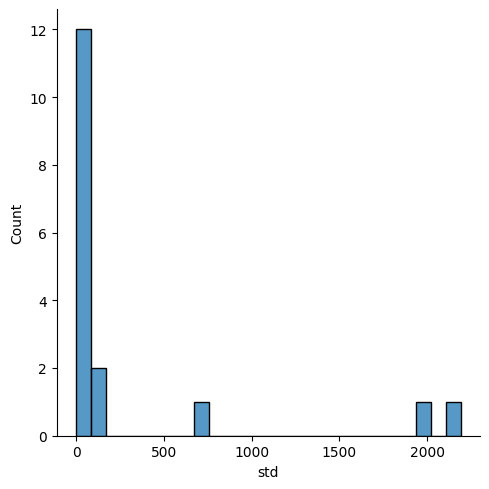

In [157]:
sns.displot(feature_std, x="std")
plt.show()

## psi检验特征稳定性

In [158]:
frac = 0.7
samp_size = int(df.shape[0]*frac)
data_train = df.iloc[:samp_size,:]
data_oot = df.iloc[samp_size:,:]

In [159]:
#======= psi检查 =============
def psi_categ(actual, expected):
    '''
    :param actual: 类别型变量
    :param expected:
    :return:
    '''
    acnt = actual.value_counts()
    ecnt = expected.value_counts()
    arate = actual.value_counts() / len(actual)
    erate = expected.value_counts() / len(expected)

    psi = np.sum((arate - erate) * np.log(arate / erate))

    return psi

def psi_contins(actual, expected, quant=10):
    '''
    :param actual: 连续型变量
    :param expected:
    :param quant:
    :return:
    '''
    minv = min(min(actual), min(expected))
    maxv = max(max(actual), max(expected))
    step = 1.0 * (maxv - minv) / quant
    acnt = []
    ecnt = []
    s, e = minv, minv + step
    act = np.array(actual)
    ex = np.array(expected)

    while e <= maxv and step != 0:
        acnt.append(((act >= s) & (act < e)).sum())
        ecnt.append(((ex >= s) & (ex < e)).sum())
        s = e
        e = e + step

    arate = np.array(acnt) / len(actual)
    erate = np.array(ecnt) / len(expected)

    arate[arate == 0] = 0.000001
    erate[erate == 0] = 0.000001

    psi = np.sum((arate - erate) * np.log(arate / erate))

    return psi

#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
#找出数值型特征名
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
num_fea.remove('label')

col_categorical = []
col_categorical_psi = []

for col in cat_fea:
    col_categorical.append(col)
    col_categorical_psi.append(psi_categ(data_train[col], data_oot[col]))
    
for col in num_fea:
    col_categorical.append(col)
    col_categorical_psi.append(psi_contins(data_train[col], data_oot[col]))

psi_df_category = pd.DataFrame()
psi_df_category['index'] = col_categorical
psi_df_category['psi'] = col_categorical_psi
#psi_df_category.to_csv(r'F:\9f\ouput_data\data_monthly_rs_psi_categorical_var_part1_part2.csv', index=False)
psi_high_var_cat = psi_df_category[psi_df_category['psi'] >=0.25]['index'].tolist()
print('由于psi值大于0.25需要删除的columns有{0}'.format(psi_high_var_cat))

由于psi值大于0.25需要删除的columns有['指标1', '指标8', '指标9', '指标10', '指标11', '指标12', '指标13', '指标15', '指标17', '指标18', '指标19', '指标20']


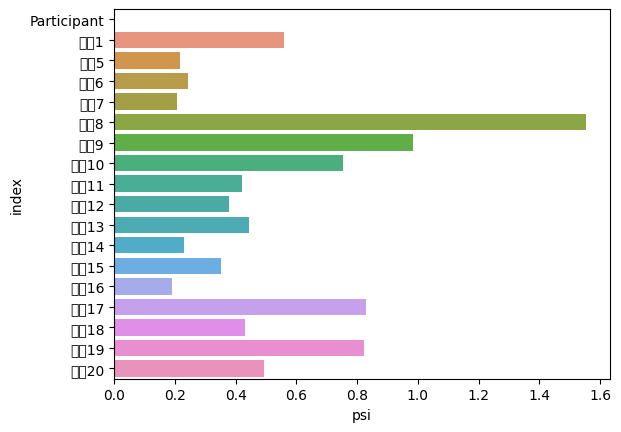

In [160]:
sns.barplot(psi_df_category, x="psi",y='index')
plt.show()

## woe-IV

In [15]:
import scorecardpy as sc

In [27]:
#找出类别型特征名
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
tst = data_train[num_fea]
# Numeric Variables  连续变量iv计算
bins_adj = sc.woebin(tst,y='label')

bin_train_df = pd.DataFrame()
for i in bins_adj.keys():
    bin_train_df = pd.concat([bin_train_df,bins_adj[i]])

breaks_list = {}
for i in bins_adj.keys():
    bin_cut = [float(i.replace('[','').replace(')','').split(',')[0]) for i in bins_adj[i]['bin'].tolist() if i !='missing']
    bin_cut.append(np.inf)
    breaks_list[i]=bin_cut
    

bins_adj = sc.woebin(data_oot[num_fea],y='label', breaks_list=breaks_list)
bin_test_df = pd.DataFrame()
for i in bins_adj.keys():
    bin_test_df = pd.concat([bin_test_df,bins_adj[i]])
final_feature = list(set(bin_train_df[bin_train_df['total_iv']>0.02]['variable'])&set(bin_test_df[bin_test_df['total_iv']>0.02]['variable']))
print('最终保留的colunms有{0}'.format(final_feature))

[INFO] creating woe binning ...


TypeError: unhashable type: 'numpy.ndarray'

## 最终删除

In [161]:
to_drop=list(set(idx_miss_drop+miss_drop+unique_drop+std_fea_drop+frep_drop+psi_high_var_cat))
print('最终需要删除的列columns为：====》{0}'.format(to_drop))
df=df.drop(to_drop,axis=1) 

最终需要删除的列columns为：====》['指标8', '指标10', '指标9', '指标12', '指标11', '指标17', '指标15', '指标20', '指标1', '指标13', '指标19', '指标18']


## 特征数值化

In [162]:
from sklearn import preprocessing
cat_fea=df.dtypes[df.dtypes=='object'].index.to_list()
num_fea=df.dtypes[df.dtypes!='object'].index.to_list()
all_fea = df.columns.to_list()
all_fea.remove("label")

modle_cat = preprocessing.OrdinalEncoder()
df.loc[:,cat_fea] = modle_cat.fit_transform(df.loc[:,cat_fea])
modle_num = preprocessing.StandardScaler()
df[all_fea] = modle_num.fit_transform(df[all_fea])

modle_label = preprocessing.OrdinalEncoder()
df[['label']] = modle_label.fit_transform(df[['label']])

df = df.convert_dtypes()
df = df.astype('float32')

## 特征相关性热力图

<Axes: >

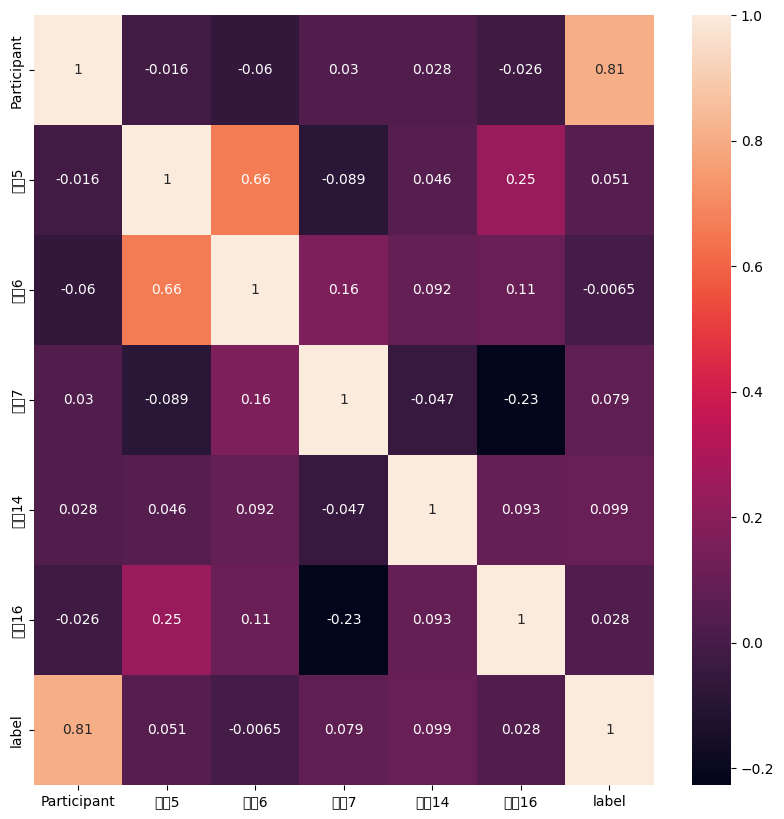

In [193]:
fea2target = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(fea2target,annot=True)

In [163]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 特征晒筛选

In [164]:
import lightgbm as lgb
num_class = len(df['label'].unique())
features = df.drop('label',axis=1)
label = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    features,
    label,
    test_size=0.2,
    random_state=1,
    
)
train_data=lgb.Dataset(X_train.values,label=y_train.values)
validation_data=lgb.Dataset(X_test.values,label=y_test.values)

params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':4,
    'objective':'multiclass',
    'num_class':num_class,
}
model=lgb.train(params,train_data,valid_sets=[validation_data])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 6
[LightGBM] [Info] Start training from score -0.409043
[LightGBM] [Info] Start training from score -1.091495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.502499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's multi_logloss: 0.437307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's multi_logloss: 0.383726
[LightGBM] [Warning] No further splits w

[89]	valid_0's multi_logloss: 0.00163678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's multi_logloss: 0.00160837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's multi_logloss: 0.00158183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's multi_logloss: 0.00155701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's multi_logloss: 0.0015338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's multi_logloss: 0.00151207
[Ligh

In [165]:
from sklearn.metrics import roc_auc_score,accuracy_score
y_pred=model.predict(X_test)
y_pred=[list(x).index(max(x)) for x in y_pred]
print('lgb的acc为：',accuracy_score(y_test.astype('int').values,y_pred))

lgb的acc为： 1.0


In [166]:
#确定最终所选特征数量
dst_fea_nb = 10
train_features = df.columns.to_list()
train_features.remove('label')
feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp']  = model.feature_importance()
feature_importance             = feature_importance.sort_values('fea_imp',ascending = False)

end_fea = feature_importance['fea_name'].values[:dst_fea_nb]
end_fea = list(end_fea)
print('最终留下的特征{}'.format(end_fea))
end_fea.append('label')

df_end = df[end_fea]

最终留下的特征['Participant', '指标14', '指标7', '指标5', '指标6', '指标16']


## smote采样

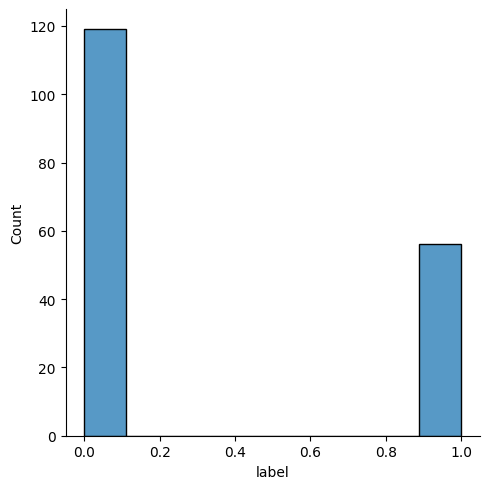

In [167]:
sns.displot(df_end, x="label")
plt.show()

In [168]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek

smote_tag = True
if smote_tag:
    sos = SMOTE(random_state=0)
    features, label = sos.fit_resample(df_end.drop('label',axis=1), df_end['label'])
else:
    features = df_end.drop('label',axis=1)
    label = df_end['label']

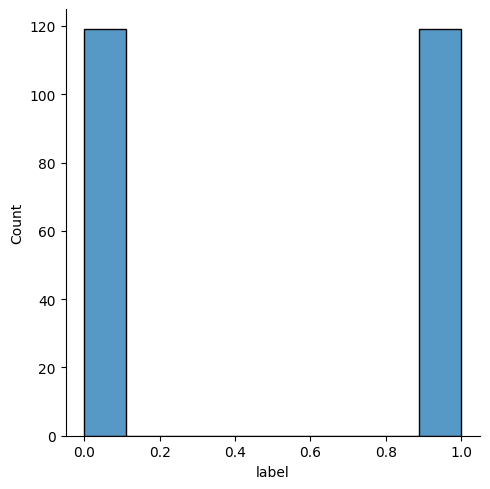

In [169]:
sns.displot(label)
plt.show()

## 数据集划分

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    label,
    test_size=0.2,
    random_state=1,
)

In [171]:
from sklearn.ensemble import RandomForestClassifier

## 随机森林

In [172]:
params = {'n_estimators':range(10,30,10)
          ,'criterion':['gini','entropy']
          ,'max_depth':range(3,10,3)
          ,'min_samples_split':range(10,30,10)
          ,'min_samples_leaf':range(5,40,10)
           }

model_rf = RandomForestClassifier()
gs_rf = GridSearchCV(estimator=model_rf,param_grid=params,cv=5,n_jobs=4)

gs_rf.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_rf.best_params_)
brf = gs_rf.best_estimator_
brf = brf.fit(X_train,  y_train.astype('int'))

最好的参数设置为：
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}


Start predicting...
Sensitivity: 1.0
Specificity: 1.0
准确率为：1.0
精确率为：1.0
召回率为：1.0
f1分数为：1.0
auc分数为：1.0


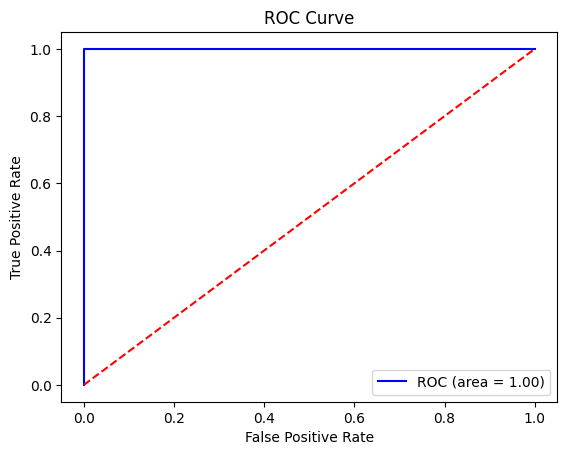

In [173]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= brf.predict(X_test)
y_pred_prob= brf.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## 逻辑回归

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

params = {'max_iter':range(100,1000,100) 
          ,'penalty':['l1','l2']
          ,'C': [0.01, 0.1, 1, 10]
           }
model_lr = LogisticRegression()
gs_lr = GridSearchCV(estimator=model_lr,param_grid=params,cv=10)

gs_lr.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_lr.best_params_)
blr = gs_lr.best_estimator_
blr = blr.fit(X_train,  y_train.astype('int'))

# model_lr = LogisticRegression(multi_class="multinomial", solver="newton-cg", max_iter=1000)
# model_lr.fit(X_train,y_train.astype('int').values)

最好的参数设置为：
{'C': 1, 'max_iter': 100, 'penalty': 'l2'}


Start predicting...
Sensitivity: 1.0
Specificity: 0.9629629629629629
准确率为：0.9791666666666666
精确率为：0.9545454545454546
召回率为：0.9814814814814814
f1分数为：0.979212373848179
auc分数为：0.9814814814814815


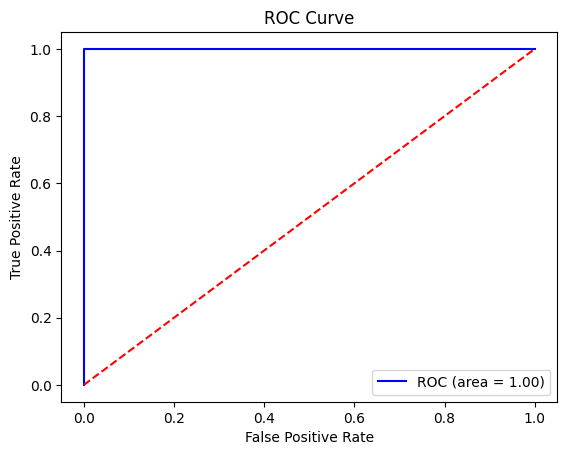

In [175]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= blr.predict(X_test)
y_pred_prob= blr.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## KNN

In [176]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

# 设置参数搜索范围
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],
}

# 使用GridSearchCV选择最佳参数组合
gs_knn = GridSearchCV(knn, param_grid, cv=4,n_jobs=4)
gs_knn.fit(X_train, y_train)
bknn = gs_knn.best_estimator_
print('最好的参数设置为：')
print(gs_knn.best_params_)
# 输出最佳参数组合
bknn = bknn.fit(X_train,  y_train.astype('int'))


最好的参数设置为：
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


Start predicting...
Sensitivity: 1.0
Specificity: 0.8148148148148148
准确率为：0.8958333333333334
精确率为：0.8076923076923077
召回率为：0.9074074074074074
f1分数为：0.8960594876248371
auc分数为：0.9074074074074074


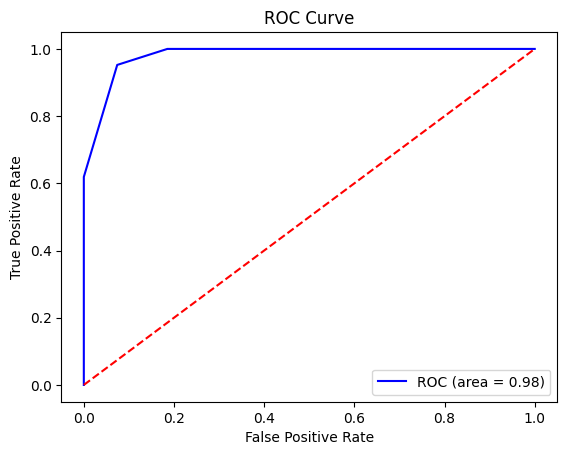

In [178]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bknn.predict(X_test)
y_pred_prob= bknn.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## 决策树

In [179]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 创建决策树分类器
dtc = DecisionTreeClassifier()

# 设置参数搜索范围
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 使用GridSearchCV选择最佳参数组合
gs_tree = GridSearchCV(dtc, param_grid, cv=10,n_jobs=4)
gs_tree.fit(X_train, y_train)

btree = gs_tree.best_estimator_
print('最好的参数设置为：')
print(gs_tree.best_params_)
# 输出最佳参数组合
btree = btree.fit(X_train,  y_train.astype('int'))

最好的参数设置为：
{'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


[Text(0.5, 0.75, 'Participant <= 0.624\ngini = 0.5\nsamples = 190\nvalue = [92, 98]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 92\nvalue = [92, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 98\nvalue = [0, 98]')]

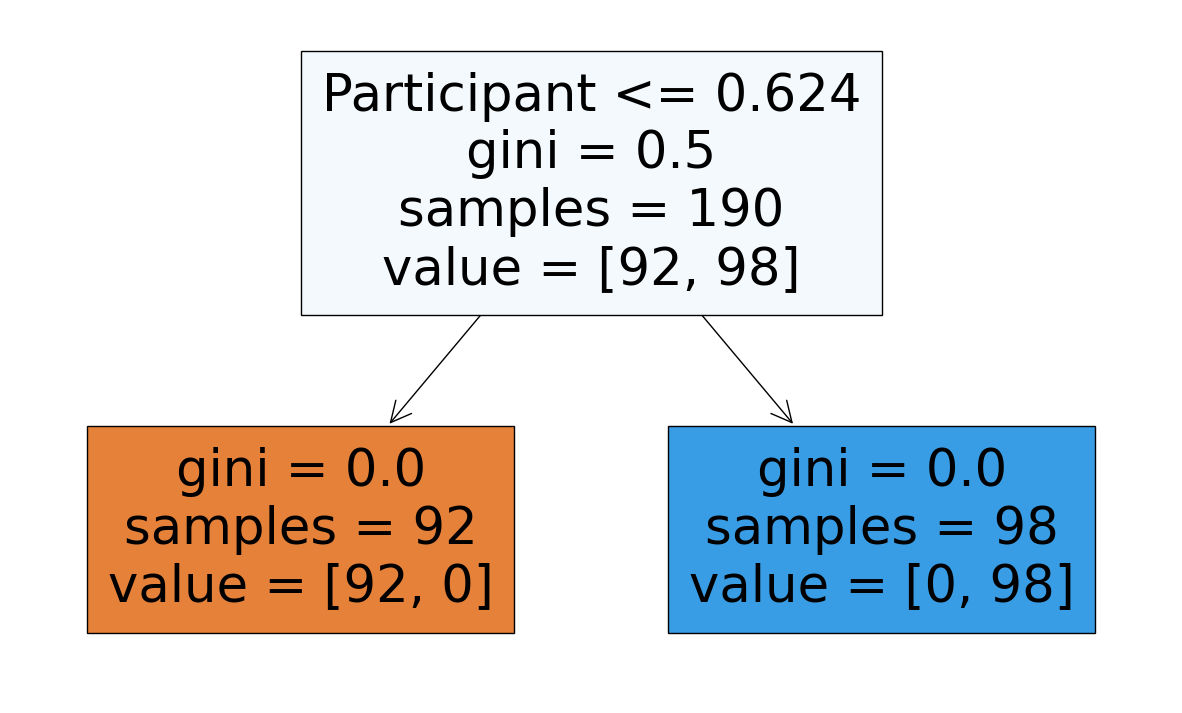

In [192]:
from sklearn import tree
plt.figure(figsize=(15,9))
tree.plot_tree(btree,filled=True,feature_names=X_train.columns)

## 特征重要性

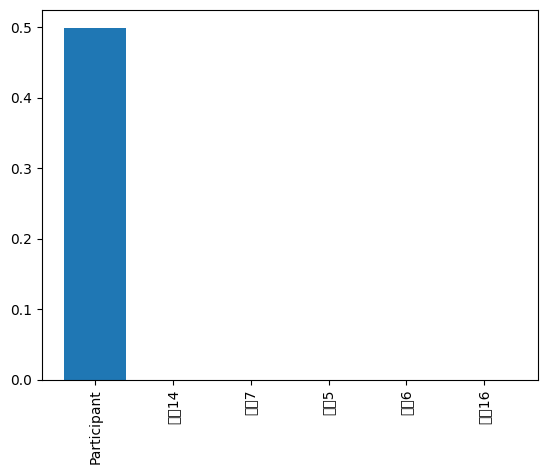

In [194]:
fea_value = btree.tree_.compute_feature_importances(normalize=False)
fea_df = pd.DataFrame()
fea_df['features'] = X_test.columns
fea_df['features_importance'] = fea_value
fea_df.sort_values(by='features_importance',ascending=False,inplace=True)

#绘制条形图
plt.bar(fea_df['features'],fea_df['features_importance'])
plt.xticks(rotation=90)
plt.show()

Start predicting...
Sensitivity: 1.0
Specificity: 1.0
准确率为：1.0
精确率为：1.0
召回率为：1.0
f1分数为：1.0
auc分数为：1.0


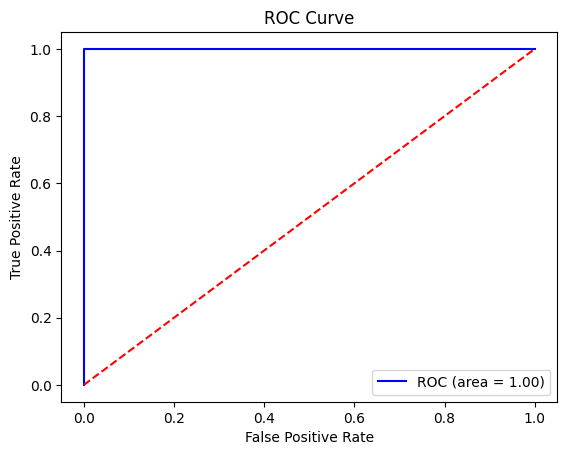

In [180]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= btree.predict(X_test)
y_pred_prob= btree.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## svm

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm

params = {'max_iter':range(100,1000,100) 
          ,'kernel': ['linear', 'rbf']
          , 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
          ,'gamma': [0.001, 0.0001]
           }
model_svm = svm.SVC(kernel="linear" ,decision_function_shape="ovo")
gs_svm = GridSearchCV(estimator=model_svm,param_grid=params,cv=10,n_jobs=4)
gs_svm.fit(X_train, y_train.astype('int').values)
print('最好的参数设置为：')
print(gs_svm.best_params_)
bsvm = gs_svm.best_estimator_
bsvm = bsvm.fit(X_train,  y_train.astype('int'))

最好的参数设置为：
{'C': 1, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': 200}


Start predicting...
Sensitivity: 1.0
Specificity: 0.9629629629629629
准确率为：0.9791666666666666
精确率为：0.9545454545454546
召回率为：0.9814814814814814
f1分数为：0.979212373848179
auc分数为：0.9814814814814815


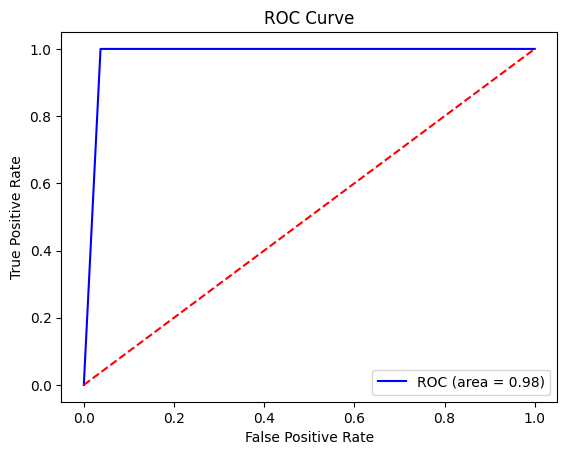

In [182]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bsvm.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## 贝叶斯

In [183]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb = model_nb.fit(X_train,  y_train.astype('int'))

Start predicting...
Sensitivity: 1.0
Specificity: 0.9629629629629629
准确率为：0.9791666666666666
精确率为：0.9545454545454546
召回率为：0.9814814814814814
f1分数为：0.979212373848179
auc分数为：0.9814814814814815


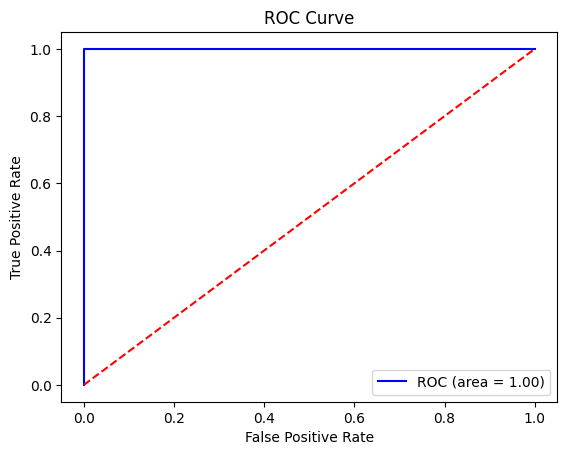

In [184]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= model_nb.predict(X_test)
y_pred_prob= model_nb.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## gbdt

In [186]:
parameter_space = {
    'n_estimators': range(100, 400, 50),
    #                   'validation_fraction':[i/10.0 for i in range(1,10)],
    'max_features': range(5, 30, 3),
    'max_leaf_nodes': range(2, 7, 1)
}

gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                 learning_rate=0.01, loss='log_loss', max_depth=16,
                                 max_features=None, max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_samples_leaf=0.05, min_samples_split=35,
                                 min_weight_fraction_leaf=0.0, n_estimators=350,
                                 n_iter_no_change=None,
                                 random_state=44, subsample=1.0, tol=0.0001,
                                 validation_fraction=0.1, verbose=0,
                                 warm_start=False)

# 计算最好的参数，如果不需要调参则注释这部分
grid = GridSearchCV(gbc, parameter_space, n_jobs=4, cv=5, verbose=5)
grid.fit(X_train, y_train.astype('int'))
print('最好的参数设置为：')
print(grid.best_params_)
bgbdt = grid.best_estimator_

bgbdt = bgbdt.fit(X_train,  y_train.astype('int'))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
最好的参数设置为：
{'max_features': 5, 'max_leaf_nodes': 2, 'n_estimators': 100}


Start predicting...
Sensitivity: 1.0
Specificity: 1.0
准确率为：1.0
精确率为：1.0
召回率为：1.0
f1分数为：1.0
auc分数为：1.0


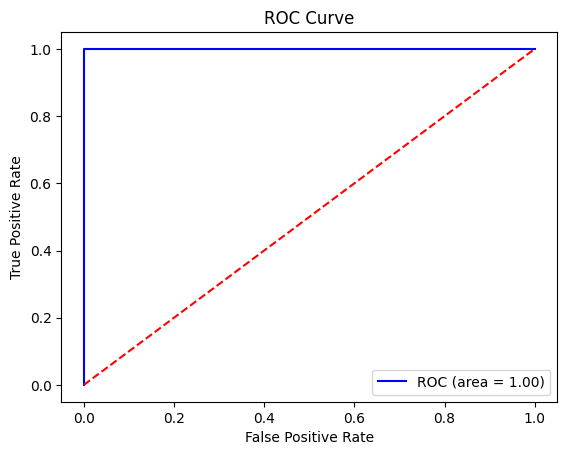

In [187]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
y_pred= bgbdt.predict(X_test)
y_pred_prob= bgbdt.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")

## 特征重要性

In [189]:
imp = bgbdt.feature_importances_.tolist()
col_name = df_end.columns.to_list()
col_name.remove('label')
fea_importance = zip(col_name,imp)
fea_importance = dict(fea_importance)
fea_importance= sorted(fea_importance.items(), key=lambda d:d[1], reverse = True)
print('特征重要性为:')
fea_importance

特征重要性为:


[('Participant', 0.9884065232642814),
 ('指标6', 0.009498091154558663),
 ('指标14', 0.002095385581159853),
 ('指标7', 0.0),
 ('指标5', 0.0),
 ('指标16', 0.0)]

## dnn

In [216]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [220]:
class Mydata(Dataset):
    def __init__(self,data):
        self.df = data.values
    def __getitem__(self,idx):
        features = self.df[idx,:-1]
        label    = self.df[idx,-1]
        return features,label
    def __len__(self):
        data_lens = self.df.shape[0]
        return data_lens

# 自定义三层神经网络，由于特征有限，且大部分特征为0，如果定义太多层神经网络，可能导致模型无法收敛
class GeneModel(nn.Module):
    def __init__(self,n_feature,n_hidden,n_output,dropout=0.5):
        super(GeneModel, self).__init__()

        self.input_layer = nn.Linear(n_feature, n_hidden)
        self.bn_layer1 = nn.BatchNorm1d(n_hidden)

        self.hidden_layer1 = nn.Linear(n_hidden,n_hidden//2)
        self.bn_layer2 = nn.BatchNorm1d(n_hidden//2)

        self.output_layer = nn.Linear(n_hidden//2,n_output)
    def forward(self,input):
        x = self.input_layer(input)
        x = F.relu(x)
        x = self.hidden_layer1(x)
        x = F.relu(self.bn_layer2(x))
        x = self.output_layer(x)
#         out = F.softmax(x,dim=1)
        x = F.sigmoid(x)
        return x

#模型训练过程
def train_loop(dataloader,model,loss_fn,optimizer,t):
    size = len(dataloader.dataset)
    for batch,(x,y) in enumerate(dataloader):
        x = x.to(torch.float32)
        pred = model(x)
        temp =  torch.Tensor([i.argmax() for i in pred])
        loss = loss_fn(pred,y.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
# 模型测试过程
def test_loop(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    test_loss,correct = 0,0
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(torch.float32)
            pred = model(x)
            test_loss += loss_fn(pred,y.long()).item()
            correct += (pred.argmax(1) == y.long()).type(torch.float).sum().item()

    test_loss /= num_batchs
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [221]:
train_data = X_train
train_data['label'] = y_train
test_data = X_test
test_data['label'] = y_test

train_Dataset = Mydata(train_data)
test_Dataset = Mydata(test_data)
train_dataloader = DataLoader(train_Dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=8, shuffle=True)
# 2. 模型定义
n_feature = df_end.shape[1] - 1 #特征个数
n_hidden = 200   #隐藏层的神经元自己随意设置，可调
n_output = len(df_end['label'].unique())    #由于是四分类，所以输出是4,不可调
model = GeneModel(n_feature,n_hidden,n_output)

# 3.模型训练
#   3.1超参设置
learning_rate = 1e-3
epochs = 100
#   3.2.设置损失函数和优化函数
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

#   3.3.开始训练
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.706320  [    0/  190]
Test Error: 
 Accuracy: 60.4%, Avg loss: 0.677577 

Epoch 2
-------------------------------
loss: 0.657003  [    0/  190]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.667240 

Epoch 3
-------------------------------
loss: 0.719210  [    0/  190]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.661242 

Epoch 4
-------------------------------
loss: 0.700935  [    0/  190]
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.662518 

Epoch 5
-------------------------------
loss: 0.668735  [    0/  190]
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.655064 

Epoch 6
-------------------------------
loss: 0.628998  [    0/  190]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.652875 

Epoch 7
-------------------------------
loss: 0.656509  [    0/  190]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.641337 

Epoch 8
-------------------------------
loss: 0.662529  [    0/  190]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.635925 

Epoch 9
----------------

loss: 0.486371  [    0/  190]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.483050 

Epoch 71
-------------------------------
loss: 0.432836  [    0/  190]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.497894 

Epoch 72
-------------------------------
loss: 0.453970  [    0/  190]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.483018 

Epoch 73
-------------------------------
loss: 0.440343  [    0/  190]
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.471957 

Epoch 74
-------------------------------
loss: 0.476522  [    0/  190]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.490984 

Epoch 75
-------------------------------
loss: 0.471192  [    0/  190]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.479336 

Epoch 76
-------------------------------
loss: 0.467518  [    0/  190]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.472700 

Epoch 77
-------------------------------
loss: 0.472528  [    0/  190]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.506138 

Epoch 78
-------------------------------
loss: 0.598526  

Start predicting...
Sensitivity: 1.0
Specificity: 0.8518518518518519
准确率为：0.9166666666666666
精确率为：0.84
召回率为：0.9259259259259259
f1分数为：0.9169565217391304
auc分数为：0.9259259259259259


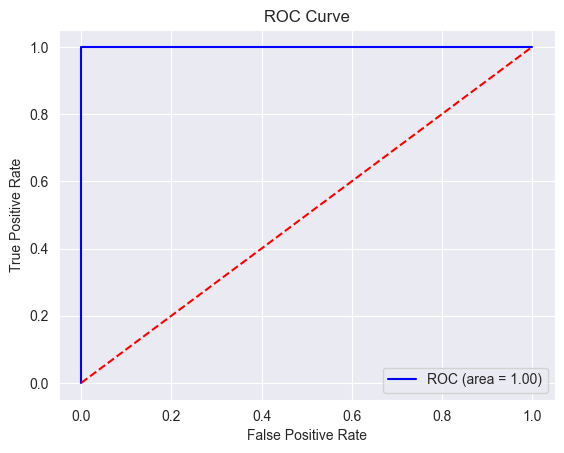

In [225]:
feature = test_data.drop('label',axis=1)
feature = torch.Tensor(feature.values)
label = test_data['label']
model.eval()
pred_tmp = model(feature)
data = pred_tmp.detach().numpy()
y_pred_prob = data[:,1]
y_pred = [i.argmax() for i in data]

from sklearn import metrics
import matplotlib.pyplot as plt

print('Start predicting...')
confusion = confusion_matrix(y_test,y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('Sensitivity:',TP / float(TP+FN))
print('Specificity:',TN / float(TN+FP))  
acc = metrics.accuracy_score(y_test, y_pred) 
print('准确率为：{}'.format(acc))
# 计算精确度
precision = precision_score(y_test, y_pred)
print('精确率为：{}'.format(precision))
rcall = metrics.recall_score(y_test, y_pred,average='macro') 
print('召回率为：{}'.format(rcall))
f1 = metrics.f1_score(y_test, y_pred,average='weighted') 
print('f1分数为：{}'.format(f1))
auc = metrics.roc_auc_score(y_test, y_pred) 
print('auc分数为：{}'.format(auc))


fpr, tpr, thersholds = metrics.roc_curve(y_test, y_pred_prob,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='ROC (area = {0:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('ROC Curve')
plt.legend(loc="lower right")